# Лабораторная работа 5. Свёрточные сети

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import torchvision
import random
import numpy as np
import matplotlib.pyplot as plt

# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [2]:
manualSeed = 42
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  42


Загрузим датасет [`FashionMNIST`](https://docs.pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html) и визуализируем примеры изображений из него.

In [3]:
batch_size = 64
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
train_set = torchvision.datasets.FashionMNIST(root='FashionMNIST', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_set = torchvision.datasets.FashionMNIST(root='FashionMNIST', train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

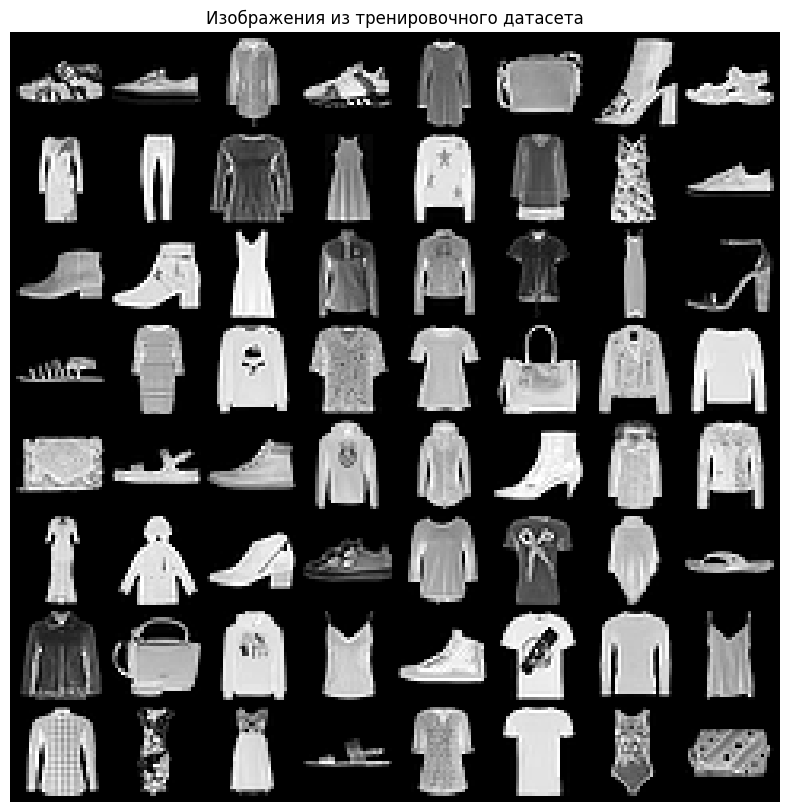

In [4]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

real_batch = next(iter(train_loader))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

plt.figure(figsize=(10,10))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), normalize=True).cpu(),(1,2,0)))
plt.axis("off")
plt.title("Изображения из тренировочного датасета")
plt.show()

#### Задание 1.
Постройте свёрточную сеть `LeNet-5`. Используя созданные `train_loader` и `val_loader`, обучите модель распознавать одежду из датасета `FashionMNIST`.

Поэкспериментируйте с гиперпараметрами и постарайтесь достичь точности (`accuracy`) распознавания не менее `0.8` на валидационной подвыборке.

In [5]:
# Определение модели LeNet-5
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.classifier(x)
        return x

# Загрузка данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = datasets.FashionMNIST(root='FashionMNIST', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)

val_set = datasets.FashionMNIST(root='FashionMNIST', train=False, download=True, transform=transform)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)

# Инициализация модели, оптимизатора и функции потерь
model = LeNet5(num_classes=10)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Обучение модели
num_epochs = 10
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Эпоха {epoch+1}/{num_epochs}, Потери: {running_loss/len(train_loader):.4f}")

    # Валидация
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Точность на валидационном наборе: {accuracy:.2f}%")

print("Обучение завершено!")


Эпоха 1/10, Потери: 0.5927
Точность на валидационном наборе: 84.59%
Эпоха 2/10, Потери: 0.3749
Точность на валидационном наборе: 86.06%
Эпоха 3/10, Потери: 0.3242
Точность на валидационном наборе: 87.07%
Эпоха 4/10, Потери: 0.2942
Точность на валидационном наборе: 88.60%
Эпоха 5/10, Потери: 0.2705
Точность на валидационном наборе: 88.84%
Эпоха 6/10, Потери: 0.2535
Точность на валидационном наборе: 88.79%
Эпоха 7/10, Потери: 0.2381
Точность на валидационном наборе: 89.60%
Эпоха 8/10, Потери: 0.2239
Точность на валидационном наборе: 89.55%
Эпоха 9/10, Потери: 0.2132
Точность на валидационном наборе: 90.02%
Эпоха 10/10, Потери: 0.2046
Точность на валидационном наборе: 89.87%
Обучение завершено!


#### Задание 2.
Поэкспериментировуйте с параметрами `LeNet-5` и найдите оптимальную архитектуру для `FashionMNIST`.  

Параметры для подбора:
- количество свёрточных слоев
- функция активации (Tanh, ReLU)
- способ субдискретизации (Average, Max)
- размер фильтров
- количество фильтров

Какую наилучшую точность получилось достичь на валидационной подвыборке?

In [ ]:
# Определение модели LeNet-5 с возможностью настройки
class ConfigurableLeNet5(nn.Module):
    def __init__(self, num_classes=10, conv_layers=2, activation='ReLU', pooling='Max',
                 filter_sizes=[5, 5], num_filters=[6, 16]):
        super(ConfigurableLeNet5, self).__init__()
        self.features = nn.Sequential()
        in_channels = 1  # Для FashionMNIST - 1 канал (grayscale)

        for i in range(conv_layers):
            padding = filter_sizes[i] // 2 if i == 0 else 0  # Padding для первого слоя, чтобы сохранить размер
            self.features.add_module(f'conv{i+1}', nn.Conv2d(in_channels, num_filters[i],
                                                            kernel_size=filter_sizes[i], padding=padding))
            if activation == 'ReLU':
                self.features.add_module(f'relu{i+1}', nn.ReLU())
            elif activation == 'Tanh':
                self.features.add_module(f'tanh{i+1}', nn.Tanh())

            if pooling == 'Max':
                self.features.add_module(f'pool{i+1}', nn.MaxPool2d(kernel_size=2, stride=2))
            elif pooling == 'Average':
                self.features.add_module(f'pool{i+1}', nn.AvgPool2d(kernel_size=2, stride=2))

            in_channels = num_filters[i]

        # Вычисление размера выхода сверточных слоев для полносвязных слоев
        dummy_input = torch.randn(1, 1, 28, 28)  # Размер изображения FashionMNIST
        with torch.no_grad():
            output = self.features(dummy_input)
            flattened_size = output.view(-1).shape[0]

        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Загрузка данных (как в предыдущем примере)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = datasets.FashionMNIST(root='FashionMNIST', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)

val_set = datasets.FashionMNIST(root='FashionMNIST', train=False, download=True, transform=transform)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)

# Функция для обучения и валидации
def train_and_validate(model, optimizer, criterion, num_epochs=10, device=device):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Эпоха {epoch+1}/{num_epochs}, Потери: {running_loss/len(train_loader):.4f}")

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Точность на валидационном наборе: {accuracy:.2f}%")
    return accuracy

# Пример использования и экспериментов
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

# Список экспериментов для запуска
experiments = [
    {'conv_layers': 2, 'activation': 'ReLU', 'pooling': 'Max', 'filter_sizes': [5, 5], 'num_filters': [6, 16]},  # Базовая LeNet-5 (для сравнения)
    {'conv_layers': 2, 'activation': 'ReLU', 'pooling': 'Max', 'filter_sizes': [3, 3], 'num_filters': [12, 24]},  # Меньшие фильтры, больше фильтров
    {'conv_layers': 2, 'activation': 'ReLU', 'pooling': 'Max', 'filter_sizes': [5, 5], 'num_filters': [12, 32]},  # Больше фильтров
    {'conv_layers': 2, 'activation': 'Tanh', 'pooling': 'Average', 'filter_sizes': [5, 5], 'num_filters': [6, 16]},  # Tanh и Average
    {'conv_layers': 3, 'activation': 'ReLU', 'pooling': 'Max', 'filter_sizes': [3, 3, 3], 'num_filters': [8, 16, 32]},  # 3 слоя
    {'conv_layers': 2, 'activation': 'ReLU', 'pooling': 'Max', 'filter_sizes': [3, 5], 'num_filters': [16, 32]},  # Разные размеры фильтров
]

results = {}
for i, params in enumerate(experiments):
    print(f"\nЭксперимент {i+1}: {params}")
    model = ConfigurableLeNet5(**params)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    accuracy = train_and_validate(model, optimizer, criterion, device=device)
    results[f"Эксперимент {i+1}"] = accuracy

print("\nРезультаты всех экспериментов:")
for name, accuracy in results.items():
    print(f"{name}: {accuracy:.2f}%")



Эксперимент 1: {'conv_layers': 2, 'activation': 'ReLU', 'pooling': 'Max', 'filter_sizes': [5, 5], 'num_filters': [6, 16]}


Эпоха 1/10, Потери: 0.5831
Точность на валидационном наборе: 84.40%
Эпоха 2/10, Потери: 0.3652
Точность на валидационном наборе: 86.87%
Эпоха 3/10, Потери: 0.3157
Точность на валидационном наборе: 88.19%
Эпоха 4/10, Потери: 0.2892
Точность на валидационном наборе: 88.68%
Эпоха 5/10, Потери: 0.2663
Точность на валидационном наборе: 89.11%
Эпоха 6/10, Потери: 0.2517
Точность на валидационном наборе: 89.43%
Эпоха 7/10, Потери: 0.2345
Точность на валидационном наборе: 89.27%
Эпоха 8/10, Потери: 0.2218
Точность на валидационном наборе: 90.25%
Эпоха 9/10, Потери: 0.2090
Точность на валидационном наборе: 90.62%
Эпоха 10/10, Потери: 0.1976
Точность на валидационном наборе: 89.98%

Эксперимент 2: {'conv_layers': 2, 'activation': 'ReLU', 'pooling': 'Max', 'filter_sizes': [3, 3], 'num_filters': [12, 24]}
Эпоха 1/10, Потери: 0.5419
Точность на валидационном наборе: 85.80%
Эпоха 2/10, Потери: 0.3473
Точность на валидационном наборе: 85.89%
Эпоха 3/10, Потери: 0.3005
Точность на валидационном наборе

#### Задание 3 (факультативное).
Построить свёрточную сеть по одной из рассмотренных архитектур (AlexNet, VGG, Inception, ResNet) и обучить её распознаванию MNIST (FashionMNIST, CIFAR10).

Эпоха [1/15], Шаг [200/938], Потери: 0.6398
Эпоха [1/15], Шаг [400/938], Потери: 0.4406
Эпоха [1/15], Шаг [600/938], Потери: 0.3278
Эпоха [1/15], Шаг [800/938], Потери: 0.2980
Эпоха 1/15, Средние потери на обучении: 0.5615
Точность на валидационном наборе после эпохи 1: 87.04%
Эпоха [2/15], Шаг [200/938], Потери: 0.3003
Эпоха [2/15], Шаг [400/938], Потери: 0.2881
Эпоха [2/15], Шаг [600/938], Потери: 0.2991
Эпоха [2/15], Шаг [800/938], Потери: 0.3711
Эпоха 2/15, Средние потери на обучении: 0.3054
Точность на валидационном наборе после эпохи 2: 89.88%
Эпоха [3/15], Шаг [200/938], Потери: 0.4043
Эпоха [3/15], Шаг [400/938], Потери: 0.2950
Эпоха [3/15], Шаг [600/938], Потери: 0.2601
Эпоха [3/15], Шаг [800/938], Потери: 0.1769
Эпоха 3/15, Средние потери на обучении: 0.2522
Точность на валидационном наборе после эпохи 3: 90.54%
Эпоха [4/15], Шаг [200/938], Потери: 0.2610
Эпоха [4/15], Шаг [400/938], Потери: 0.0951
Эпоха [4/15], Шаг [600/938], Потери: 0.1292
Эпоха [4/15], Шаг [800/938], Потер

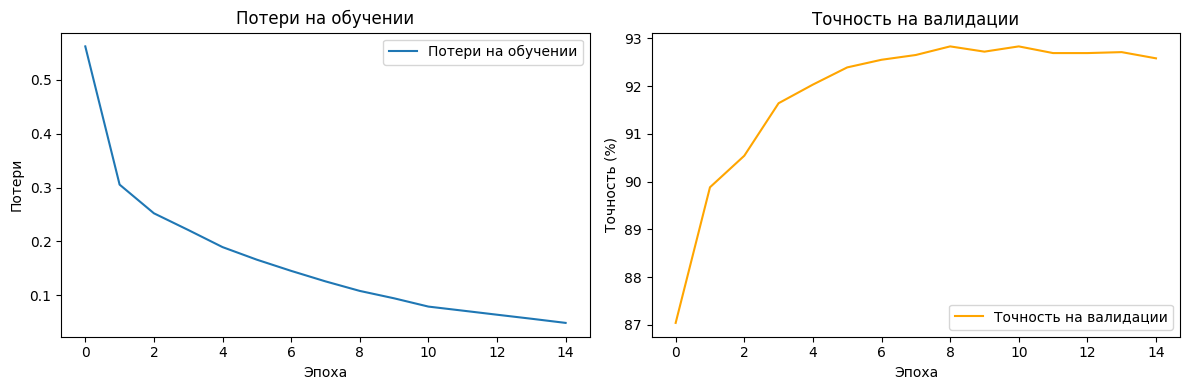

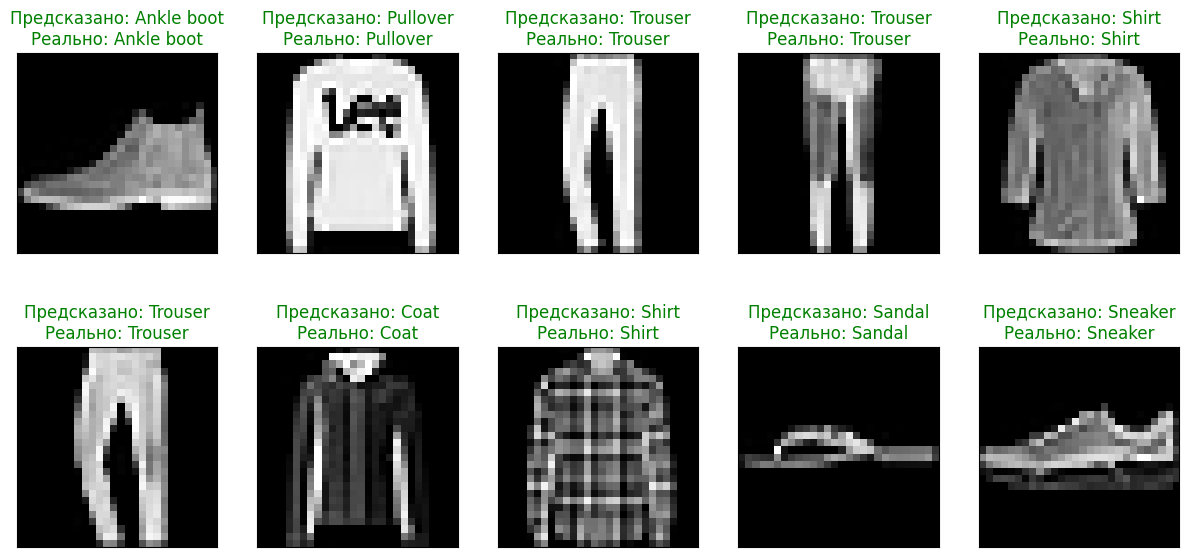

In [ ]:
# Определяем VGG-подобную модель
class VGGStyleNet(nn.Module):
    def __init__(self, num_classes=10, in_channels=1): # in_channels=1 для FashionMNIST (grayscale)
        super(VGGStyleNet, self).__init__()
        self.features = nn.Sequential(
            # Блок 1
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 28x28 -> 14x14

            # Блок 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 14x14 -> 7x7

            # Блок 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # nn.Conv2d(256, 256, kernel_size=3, padding=1), # Можно добавить еще один слой
            # nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 7x7 -> 3x3 (для FashionMNIST 28x28)
        )
        
        # Для FashionMNIST (28x28)
        self.classifier_input_features = 256 * 3 * 3 

        self.classifier = nn.Sequential(
            nn.Linear(self.classifier_input_features, 1024), # Уменьшим для FashionMNIST, чтобы избежать переобучения
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Выравнивание
        x = self.classifier(x)
        return x

# Загрузка данных FashionMNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Нормализация для FashionMNIST
])


# Инициализация модели, оптимизатора и функции потерь
model = VGGStyleNet(num_classes=10, in_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005) # Уменьшим learning rate для более глубокой сети
criterion = nn.CrossEntropyLoss()

# Обучение модели
num_epochs = 15 # Можно увеличить для лучшей точности
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if (i + 1) % 200 == 0:
            print(f"Эпоха [{epoch+1}/{num_epochs}], Шаг [{i+1}/{len(train_loader)}], Потери: {loss.item():.4f}")
            
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Эпоха {epoch+1}/{num_epochs}, Средние потери на обучении: {epoch_loss:.4f}")

    # Валидация
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)
    print(f"Точность на валидационном наборе после эпохи {epoch+1}: {accuracy:.2f}%")

print("Обучение завершено!")

# Визуализация процесса обучения
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Потери на обучении')
plt.title('Потери на обучении')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Точность на валидации', color='orange')
plt.title('Точность на валидации')
plt.xlabel('Эпоха')
plt.ylabel('Точность (%)')
plt.legend()
plt.tight_layout()
plt.show()

# Пример предсказаний (опционально)
dataiter = iter(val_loader)
images, labels = next(dataiter)
images_gpu = images.to(device)
labels_gpu = labels.to(device)

outputs = model(images_gpu)
_, predicted = torch.max(outputs, 1)

fig = plt.figure(figsize=(15, 7))
for idx in np.arange(10): # Показать первые 10 изображений из батча
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    img = images[idx] / 2 + 0.5 # денормализация
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
    ax.set_title(f"Предсказано: {classes[predicted[idx].item()]}\nРеально: {classes[labels[idx].item()]}",
                 color=("green" if predicted[idx]==labels[idx] else "red"))
plt.show()


#### Задание 4 (факультативное).
Прочитать параграф 5.3 в учебнике С. Николенко и др. (стр. 199–206) и воспроизвести рассмотренные там нейронные сети на TensorFlow и Keras.